In [1]:
# create 3 pandas datasets with the data of selected compounds and the corresponding average movement speed of the animal
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# options
log_transform = True
exclude_outliers = False
normalize = False
median_norm_cols = False

In [3]:
# raw data files list
files_list = ['List_of_detected_peak_pairs_vivoDay1_0619.csv', '10_InVivo_Dansyl.csv', '11_InVivo_Dansyl.csv']
# read data
dfs = [pd.read_csv(f) for f in files_list]

In [4]:
Tier3 = dfs[2]['Compound'].isna() * dfs[2]['Compound.1'].isna()
# merge dfs[2] compound names
dfs[2]['Compound'] = dfs[2]['Compound'].fillna(dfs[2]['Compound.1'])
# merge RT Error
dfs[2]['RT Error (s)'] = dfs[2]['RT Error (s)'].fillna(dfs[2]['RT Error (s).1'])
# merge NovaMT Library No.
dfs[2]['NovaMT Library No.'] = dfs[2]['NovaMT Library No.'].fillna(dfs[2]['NovaMT Library No..1'])
# rename Unnamed: 9 to Identification Level
dfs[2] = dfs[2].rename(columns={'Unnamed: 9': 'Identification Level'})

In [5]:
dfs[2].columns[:25]

Index(['No', 'RT (s)', 'Normalized RT (s)', 'm/z_light', 'm/z_heavy',
       'Neutral Mass (Da)', 'Intensity', 'nCharge', 'nTag',
       'Identification Level', 'NovaMT Library No.', 'External Identifier',
       'Compound', 'Mass Error (ppm)', 'RT Error (s)', 'NovaMT Library No..1',
       'External Identifier.1', 'Compound.1', 'Mass Error (ppm).1',
       'RT Error (s).1', 'Zero-reaction', 'One-reaction', 'Two-reaction',
       'Unnamed: 23', 'Mor'],
      dtype='object')

In [6]:
dfs[2]['NovaMT Library No.']

0       AN01496000
1              NaN
2              NaN
3              NaN
4       AN00655000
           ...    
1823           NaN
1824           NaN
1825           NaN
1826           NaN
1827           NaN
Name: NovaMT Library No., Length: 1828, dtype: object

In [7]:
# Filter for Tier 1&2 compounds
tier_dfs = [df[(df["Identification Level"] == "Tier 1") + (df["Identification Level"] == "Tier 2")] for df in dfs]
# tier_dfs.append(dfs[2][Tier3 == False])
# extract compounds names
compounds = [df["Compound"].tolist() for df in tier_dfs]
novamt_ids = [df["NovaMT Library No."].tolist() for df in tier_dfs]

In [8]:
[len(c) for c in compounds]

[241, 343, 345]

In [9]:
# take intersection of compounds in all 3 datasets
common_comps = list(set(compounds[0]).intersection(set(compounds[1])).intersection(set(compounds[2])))
# common novaMT for all 3 datasets
common_novamt = list(set(novamt_ids[0]).intersection(set(novamt_ids[1])).intersection(set(novamt_ids[2])))
# sort common novaMT
common_novamt.sort()
# # sort common compounds
common_comps.sort()
# pubchem_ids = []
# for comp in common_comps:
#     pubchem_id = tier_dfs[0][tier_dfs[0]["Compound"] == comp]["PubChem_ID"].values
#     if len(pubchem_id) > 0:
#         pubchem_ids.append(int(pubchem_id[0]))
#     else:
#         pubchem_ids.append(None)

In [10]:
# filter datasets for common compounds (in order!!)
# data = [td[td["NovaMT Library No."].isin(common_novamt)].reset_index(drop=True) for td in tier_dfs]
data = [td[td["Compound"].isin(common_comps)].reset_index(drop=True) for td in tier_dfs]
# order all datasets in data according to the Compound column
data = [d.sort_values("Compound").reset_index(drop=True) for d in data]



In [11]:
# data extraction and columns renaming (specific for dataset of day 1)
metadata = [d.iloc[:,:21] for d in data]
data[0] = data[0].iloc[:,21:-4]
if log_transform:
    data[0] = data[0].transform(lambda x: np.log2(x))
new_columns = []
for col in data[0].columns:
    name = col[-6:]
    if name[0] == '_':
        name = name[1:]
    new_columns.append(name)
data[0].columns = new_columns

# columns renaming (specific for dataset of day 2)
data[1] = data[1].iloc[:,21:-3]
if log_transform:
    data[1] = data[1].transform(lambda x: np.log2(x))
new_columns = []
for col in data[1].columns:
    parts = col.split('.')
    if len(parts) >= 2:
        new_col = f"{parts[0]}{int(float(parts[1])/2)+1}_{0}{int(float(parts[1])%2+1)}"
    else:
        new_col = col+"1_01"  # Default to _01 if no replicate info
    new_columns.append(new_col)
data[1].columns = new_columns

# columns renaming (specific for dataset of day 3)
data[2] = data[2].iloc[:, 24:-3]
if log_transform:
    data[2] = data[2].transform(lambda x: np.log2(x))
new_columns = []
for icol in np.arange(0,data[2].shape[1],2):
    new_columns.append(f"{int(icol/2)+1}_01")
    new_columns.append(f"{int(icol/2)+1}_02")
data[2].columns = new_columns

# hstack data
alldata = np.hstack(data)

Text(0.5, 1.0, 'Median Intensities of Samples with Bounds')

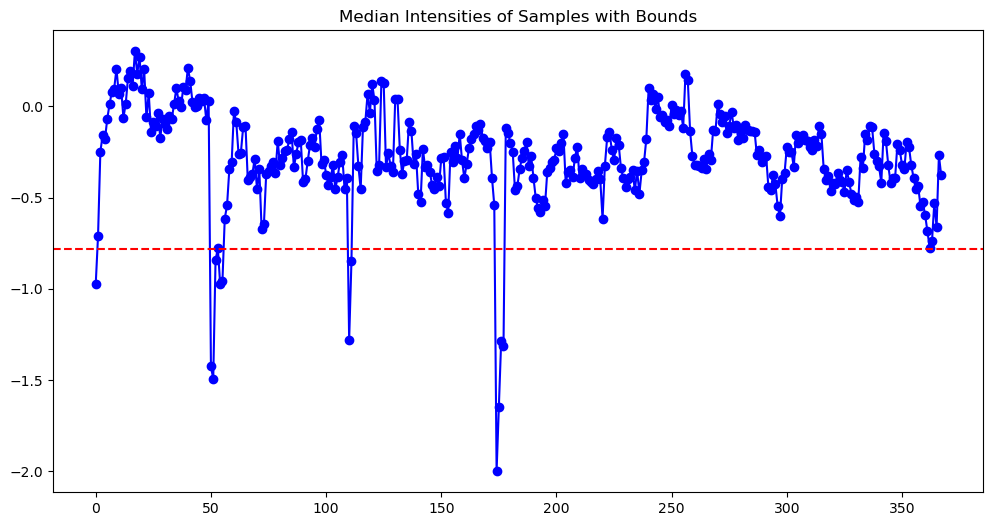

In [12]:
# check for columns with abnormally high or low values
# remove samples with intensities out of bounds (median ± 3×MAD)
median_intensities = np.median(np.median(alldata,axis=0))
mad_intensities = np.median(np.abs(np.median(alldata,axis=0) - median_intensities))
lower_bound = median_intensities - 4 * mad_intensities
# plot median intensities of each sample
plt.figure(figsize=(12, 6))
plt.plot(np.median(alldata, axis=0), marker='o', linestyle='-', color='b')
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Lower Bound')
plt.title('Median Intensities of Samples with Bounds')

In [13]:
# set columns below lower bound to NaN
for d in data:
    for col in d.columns:
        if d[col].median() < lower_bound:
            d[col] = np.nan

In [14]:
# median normalize the columns
if median_norm_cols:
    for id, d in enumerate(data):
        for i in range(d.shape[1]):
            median = np.nanmedian(d.iloc[:, i])
            mad = np.nanmedian(np.abs(d.iloc[:, i] - median))
            if mad != 0:
                d.iloc[:, i] = (d.iloc[:, i] - median) / mad

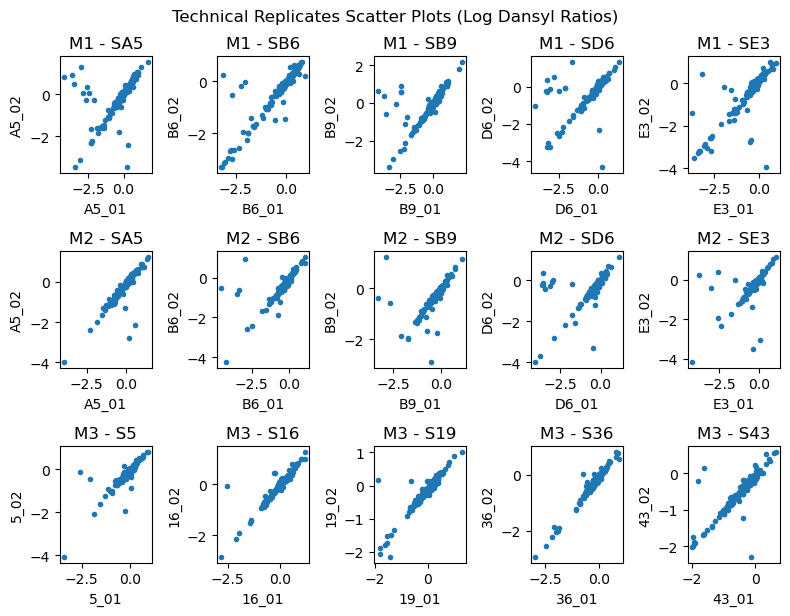

In [15]:
# check technical replicates
# plot some examples of scatter plots
plt.figure(figsize=(8, 6))
for id, d in enumerate(data):
    for icol, col in enumerate(['A5', 'B6', 'B9', 'D6', 'E3']):
        plt.subplot(3,5,5*id + icol+1)
        if id == 2:
            col = str((ord(col[0].upper()) - ord('A'))*10 + int(col[1]))
        plt.scatter(d[col+'_01'], d[col+'_02'],marker='.',rasterized=True)
        plt.title(f'M{id+1} - S{col}')
        plt.xlabel(f'{col}_01')
        plt.ylabel(f'{col}_02')
plt.tight_layout()
plt.suptitle('Technical Replicates Scatter Plots (Log Dansyl Ratios)', y=1.02)
# plt.savefig('technical_replicates_scatter_plots.pdf',dpi=300)
plt.show()

/home/nardinm@hhmi.org/anaconda3/envs/new/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_34462/2001681135.py:3: RuntimeWarning: All-NaN slice encountered
  mean = np.nanmedian([data1, data2], axis=0)
/home/nardinm@hhmi.org/anaconda3/envs/new/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


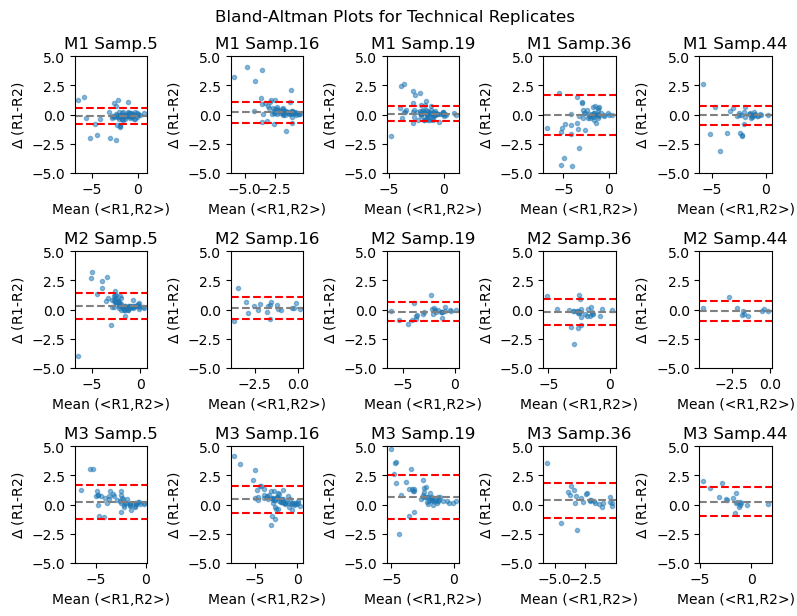

In [16]:
# bland altman plot for two technical replicates
def bland_altman_plot(data1, data2, title='Bland-Altman Plot'):
    mean = np.nanmedian([data1, data2], axis=0)
    diff = data1 - data2
    md = np.nanmedian(diff)
    sd = np.nanpercentile(diff, 75) - np.nanpercentile(diff, 25)

    # plt.figure(figsize=(8, 5))
    plt.scatter(mean, diff, alpha=0.5,marker='.',rasterized=True)
    plt.axhline(md, color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='red', linestyle='--')
    plt.axhline(md - 1.96*sd, color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('Mean (<R1,R2>)')
    plt.ylabel(r'$\Delta $ (R1-R2)')
    plt.ylim(-5,5)
    # plt.show()

plt.figure(figsize=(8, 6))
for id, d in enumerate(data):
    for icol, col in enumerate(['A5', 'B6', 'B9', 'D6', 'E4']):
        plt.subplot(3,5,5*id + icol+1)
        if id == 2:
            col = str((ord(col[0].upper()) - ord('A'))*10 + int(col[1]))
            nsamp = col
        else:
            nsamp = str((ord(col[0].upper()) - ord('A'))*10 + int(col[1]))
        bland_altman_plot(np.log2(d[col+'_01']), np.log2(d[col+'_02']),
                           title=f'M{id+1} Samp.{nsamp}')
plt.tight_layout()
plt.suptitle('Bland-Altman Plots for Technical Replicates', y=1.02)
# plt.savefig('bland_altman_plots.pdf',dpi=300)
plt.show()

In [17]:
# remove dirty technical replicates and robust-zscore
def rob_zscore(x):
    median = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - median))
    if mad == 0:
        return np.zeros_like(x)
    return (x - median) / mad

def clean_row(row, thr=1):
    # 1) compute abs difference of each consecutive pair
    row_clean = []
    for i in range(1, len(row), 2):
        diff = np.abs(row[i] - row[i-1])
        if diff > thr:
            row_clean.append(np.nan)
        else:
            row_clean.append(np.mean(row[i-1:i+1]))
    if normalize:
        row_clean = rob_zscore(row_clean)
    if exclude_outliers:
        median = np.nanmedian(row_clean)
        mad = np.nanmedian(np.abs(row_clean - median))
        row_clean = [x if np.abs(x - median) <= 3 * mad else np.nan for x in row_clean]
    return np.array(row_clean)

# do the cleaning
clean_data = []
for id, d in enumerate(data):
    clean_data.append([])
    for i in range(d.shape[0]):
        clean_data[id].append(clean_row(d.iloc[i,:].values, thr=1))
    clean_data[id] = np.array(clean_data[id])

In [18]:
len(common_comps)

155

In [19]:
# compute nan robust correlation matrix
from scipy.stats import spearmanr

In [25]:
# compute data correlations
correlation_matrices = []
for d in clean_data:
    corr_matrix, _ = spearmanr(d, axis=1, nan_policy='omit')
    correlation_matrices.append(corr_matrix)

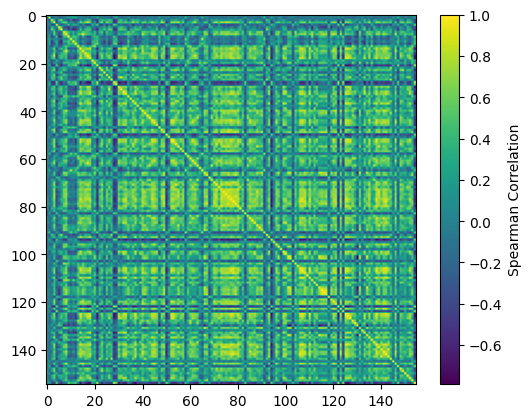

In [26]:
plt.imshow(correlation_matrices[2])
plt.colorbar(label='Spearman Correlation')

In [27]:
# import cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(correlation_matrices[0].flatten().reshape(1, -1), correlation_matrices[1].flatten().reshape(1, -1)), cosine_similarity(correlation_matrices[0].flatten().reshape(1, -1), correlation_matrices[2].flatten().reshape(1, -1))

(array([[0.5791414]]), array([[0.63315542]]))

In [28]:
clean_data[0].shape, clean_data[1].shape

((155, 55), (155, 65))

In [20]:
# for day 1 and day 2, split into morning and afternoon
# day 1 
day1_morning = clean_data[0][:, :26]
day1_afternoon = clean_data[0][:, 26:]
# day 2
day2_morning = clean_data[1][:, :32]
day2_afternoon = clean_data[1][:, 32:]
# day3
day3 = clean_data[2]
# print shapes
day1_morning.shape, day1_afternoon.shape, day2_morning.shape, day2_afternoon.shape, day3.shape

((155, 26), (155, 29), (155, 32), (155, 33), (155, 64))

In [21]:
# save cleaned data to csv file
np.savetxt('day1_morning.csv', day1_morning, delimiter=',')
np.savetxt('day1_afternoon.csv', day1_afternoon, delimiter=',')
np.savetxt('day2_morning.csv', day2_morning, delimiter=',')
np.savetxt('day2_afternoon.csv', day2_afternoon, delimiter=',')
np.savetxt('day3.csv', day3, delimiter=',')

# preprocess videos

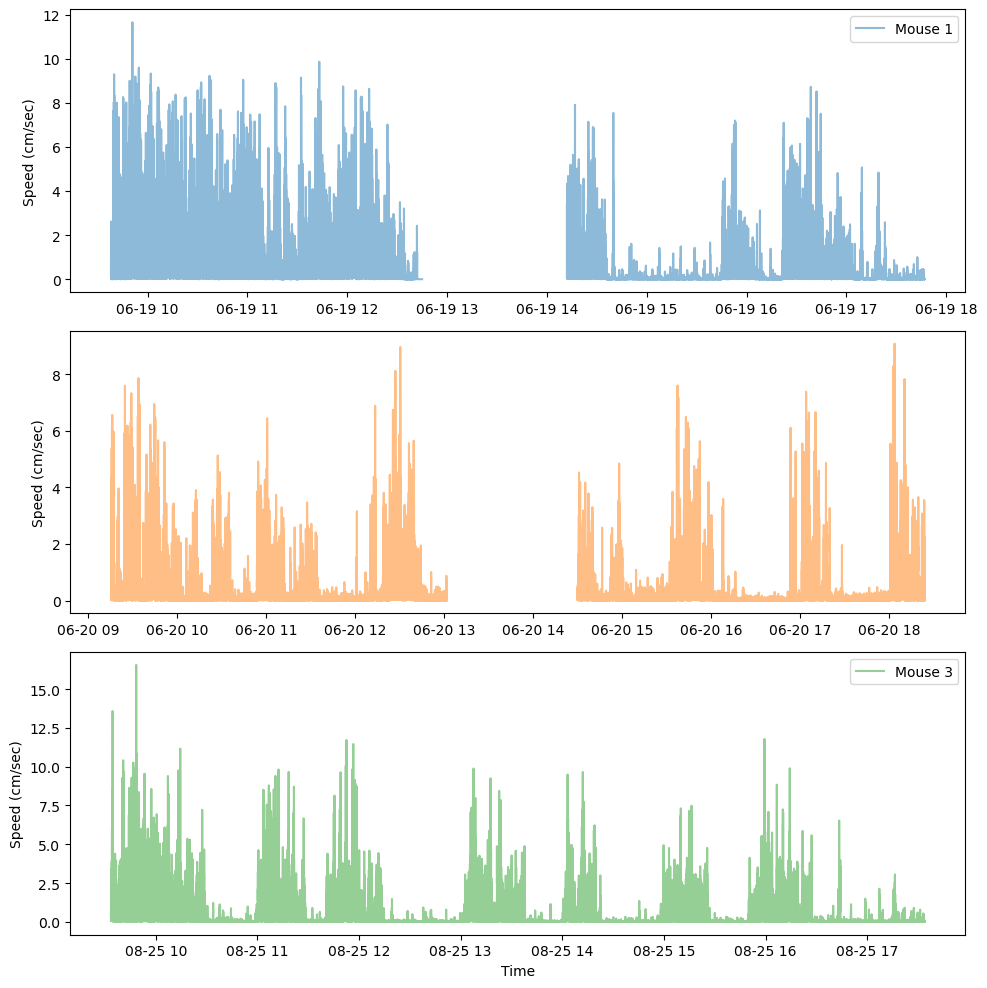

In [ ]:
# plot behavior
# put together day1_morening and day1_afternoon and be aware of the gap in between
filename = 'mn_20250619_093749DLC_clean.csv'
day1_beh_morning = pd.read_csv(filename)
day1_beh_morning['time'] = pd.to_datetime(day1_beh_morning['time'])
filename = 'mn_20250619_141151DLC_clean.csv'
day1_beh_afternoon = pd.read_csv(filename)
day1_beh_afternoon['time'] = pd.to_datetime(day1_beh_afternoon['time']) + pd.Timedelta(hours=12)  # add 12 hours to the afternoon time

filename = 'mn_20250620_142949DLC_clean.csv'
day2_beh_afternoon = pd.read_csv(filename)
day2_beh_afternoon['time'] = pd.to_datetime(day2_beh_afternoon['time']) + pd.Timedelta(hours=12)  # add 12 hours to the afternoon time
filename = 'mn_20250620_091517DLC_clean.csv'
day2_beh_morning = pd.read_csv(filename)
day2_beh_morning['time'] = pd.to_datetime(day2_beh_morning['time'])

# day 3
filename = 'mn_20250825_093313DLC_clean.csv'
day3_beh = pd.read_csv(filename)
day3_beh['time'] = pd.to_datetime(day3_beh['time'])



plt.figure(figsize=(10, 10))
plt.subplot(3,1,1)
plt.plot(day1_beh_morning['time'], day1_beh_morning['neck_speed']*2, label='Mouse 1',alpha=0.5)
plt.plot(day1_beh_afternoon['time'], day1_beh_afternoon['neck_speed']*2, color='tab:blue',alpha=0.5)
plt.ylabel('Speed (cm/sec)')
plt.legend()

plt.subplot(3,1,2)
plt.plot(day2_beh_morning['time'], day2_beh_morning['neck_speed']*2, label='Mouse 2', color='tab:orange',alpha=0.5)
plt.plot(day2_beh_afternoon['time'], day2_beh_afternoon['neck_speed']*2, color='tab:orange',alpha=0.5)
plt.ylabel('Speed (cm/sec)')

plt.subplot(3,1,3)
plt.plot(day3_beh['time'], day3_beh['neck_speed']*2, label='Mouse 3', color='tab:green',alpha=0.5)
plt.xlabel('Time')
# plt.ylabel('Speed (cm/sec)')
plt.ylabel('Speed (cm/sec)')
plt.legend()
plt.tight_layout()
# plt.savefig('behavior_speed_all_days_cm_sec.svg',dpi=300)
plt.show()

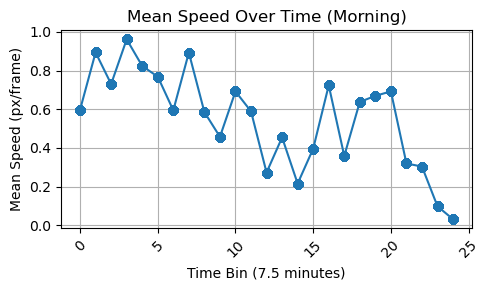

In [23]:
filename = 'mn_20250619_093749DLC_clean.csv'
day1_beh_morning = pd.read_csv(filename)
day1_beh_morning['time'] = pd.to_datetime(day1_beh_morning['time'])
morn_beh = day1_beh_morning[day1_beh_morning['time'] <= '2025-06-19 12:38:00']
day1_beh_morning['time'] = day1_beh_morning['time'].apply(lambda x: x.hour * 3600 + x.minute*60 + x.second)
# start from the first time point, and bin the data into 7.5 minute bins (450 seconds)
day1_beh_morning['time_bin'] = ((day1_beh_morning['time'] - day1_beh_morning['time'][0]) // 450)
# calculate the mean speed for each bin
day1_beh_morning['mean_speed'] = day1_beh_morning.groupby('time_bin')['neck_speed'].transform('mean')
# plot the mean speed for each bin
plt.figure(figsize=(5, 3))
plt.plot(day1_beh_morning['time_bin'], day1_beh_morning['mean_speed'], marker='o', linestyle='-')
plt.xlabel('Time Bin (7.5 minutes)')
plt.ylabel('Mean Speed (px/frame)')
plt.title('Mean Speed Over Time (Morning)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

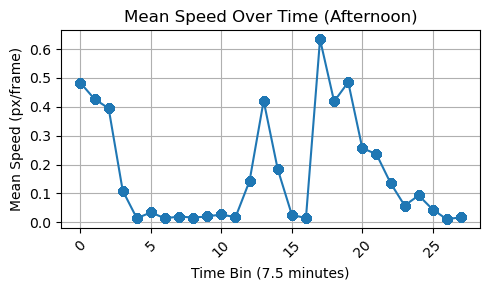

In [24]:
filename = 'mn_20250619_141151DLC_clean.csv'
day1_beh_afternoon = pd.read_csv(filename)
day1_beh_afternoon['time'] = pd.to_datetime(day1_beh_afternoon['time'])
day1_beh_afternoon = day1_beh_afternoon[day1_beh_afternoon['time'] <= '2025-06-19 05:44:00']
## there is a two minutes gap due to a power loss at time 4:06. Remove 4:06 to 4:08
day1_beh_postpowerloss = day1_beh_afternoon[day1_beh_afternoon['time'] >= '2025-06-19 04:08:00']
day1_beh_postpowerloss.loc[:,'time'] = day1_beh_postpowerloss['time'] - pd.Timedelta(minutes=2)
# remove two minutes gap
day1_beh_afternoon = pd.concat([day1_beh_afternoon[day1_beh_afternoon['time'] < '2025-06-19 04:06:00'],
                                 day1_beh_postpowerloss])
# turn everything into seconds
day1_beh_afternoon['time'] = day1_beh_afternoon['time'].apply(lambda x: x.hour * 3600 + x.minute*60 + x.second)
# start from the first time point, and bin the data into 7.5 minute bins (450 seconds)
day1_beh_afternoon['time_bin'] = ((day1_beh_afternoon['time'] - day1_beh_afternoon['time'][0]) // 450)
# calculate the mean speed for each bin
day1_beh_afternoon['mean_speed'] = day1_beh_afternoon.groupby('time_bin')['neck_speed'].transform('mean')
# plot the mean speed for each bin
plt.figure(figsize=(5, 3))
plt.plot(day1_beh_afternoon['time_bin'], day1_beh_afternoon['mean_speed'], marker='o', linestyle='-')
plt.xlabel('Time Bin (7.5 minutes)')
plt.ylabel('Mean Speed (px/frame)')
plt.title('Mean Speed Over Time (Afternoon)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

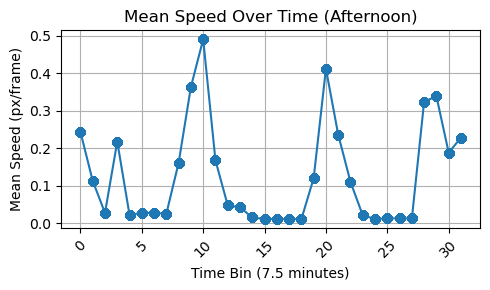

In [25]:
filename = 'mn_20250620_142949DLC_clean.csv'
day2_beh_afternoon = pd.read_csv(filename)
day2_beh_afternoon['time'] = pd.to_datetime(day2_beh_afternoon['time'])
day2_beh_afternoon['time'] = day2_beh_afternoon['time'].apply(lambda x: x.hour * 3600 + x.minute*60 + x.second)
# start from the first time point, and bin the data into 7.5 minute bins (450 seconds)
day2_beh_afternoon['time_bin'] = ((day2_beh_afternoon['time'] - day2_beh_afternoon['time'][0]) // 450)
# calculate the mean speed for each bin
day2_beh_afternoon['mean_speed'] = day2_beh_afternoon.groupby('time_bin')['neck_speed'].transform('mean')
# plot the mean speed for each bin
plt.figure(figsize=(5, 3))
plt.plot(day2_beh_afternoon['time_bin'], day2_beh_afternoon['mean_speed'], marker='o', linestyle='-')
plt.xlabel('Time Bin (7.5 minutes)')
plt.ylabel('Mean Speed (px/frame)')
plt.title('Mean Speed Over Time (Afternoon)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

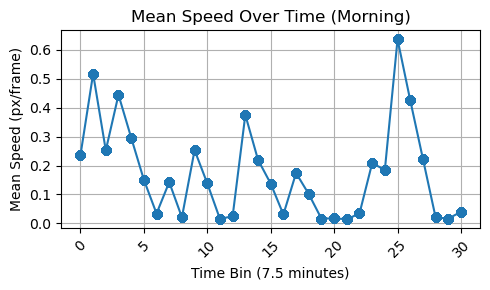

In [26]:
filename = 'mn_20250620_091517DLC_clean.csv'
day2_beh_morning = pd.read_csv(filename)
day2_beh_morning['time'] = pd.to_datetime(day2_beh_morning['time'])
day2_beh_morning['time'] = day2_beh_morning['time'].apply(lambda x: x.hour * 3600 + x.minute*60 + x.second)
# start from the first time point, and bin the data into 7.5 minute bins (450 seconds)
day2_beh_morning['time_bin'] = ((day2_beh_morning['time'] - day2_beh_morning['time'][0]) // 450)
# calculate the mean speed for each bin
day2_beh_morning['mean_speed'] = day2_beh_morning.groupby('time_bin')['neck_speed'].transform('mean')
# plot the mean speed for each bin
plt.figure(figsize=(5, 3))
plt.plot(day2_beh_morning['time_bin'], day2_beh_morning['mean_speed'], marker='o', linestyle='-')
plt.xlabel('Time Bin (7.5 minutes)')
plt.ylabel('Mean Speed (px/frame)')
plt.title('Mean Speed Over Time (Morning)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

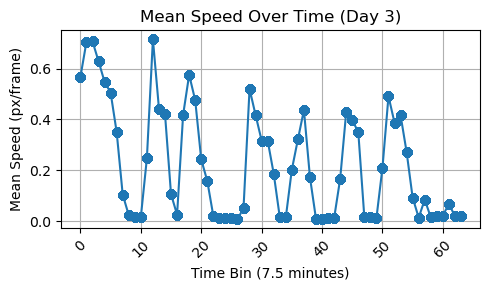

In [27]:
filename = 'mn_20250825_093313DLC_clean.csv'
day3_beh = pd.read_csv(filename)
day3_beh['time'] = pd.to_datetime(day3_beh['time'])
day3_beh = day3_beh[day3_beh['time'] <= '2025-08-25 17:33:00']
# # turn everything into seconds
day3_beh['time'] = day3_beh['time'].apply(lambda x: x.hour * 3600 + x.minute*60 + x.second)
# # start from the first time point, and bin the data into 7.5 minute bins (450 seconds)
day3_beh['time_bin'] = ((day3_beh['time'] - day3_beh['time'][0]) // 450)
# # calculate the mean speed for each bin
day3_beh['mean_speed'] = day3_beh.groupby('time_bin')['neck_speed'].transform('mean')
# plot the mean speed for each bin
plt.figure(figsize=(5, 3))
plt.plot(day3_beh['time_bin'], day3_beh['mean_speed'], marker='o', linestyle='-')
plt.xlabel('Time Bin (7.5 minutes)')
plt.ylabel('Mean Speed (px/frame)')
plt.title('Mean Speed Over Time (Day 3)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [28]:
### align!!!

In [29]:
# select only the unique values of mean speed (in order)
day1_morning_meanspeed = day1_beh_morning['mean_speed'].unique()
day1_afternoon_meanspeed = day1_beh_afternoon['mean_speed'].unique()
day2_morning_meanspeed = day2_beh_morning['mean_speed'].unique()
day2_afternoon_meanspeed = day2_beh_afternoon['mean_speed'].unique()
day3_meanspeed = day3_beh['mean_speed'].unique()
# print lengths
len(day1_morning_meanspeed), len(day1_afternoon_meanspeed), len(day2_morning_meanspeed), len(day2_afternoon_meanspeed), len(day3_meanspeed)

(25, 28, 31, 32, 64)

In [30]:
day3.shape

(155, 64)

In [31]:
# we measured a delay of 15 minutes. So 2 bins delay for the hormones in order to be aligned!
X1m = day1_morning[:, 2:]  # remove first two samples to align with behavior
X1a = day1_afternoon[:, 2:]  # remove first two samples to align with behavior
X2m = day2_morning[:, 2:]  # remove first two samples to align with behavior
X2a = day2_afternoon[:, 2:]  # remove first two samples to align with behavior
X3 = day3[:,2:] # remove first 15 minutes
y1m = day1_morning_meanspeed[:-1]  # remove last two samples to align with hormones
y1a = day1_afternoon_meanspeed[:-1]  # remove last two samples to align with hormones
y2m = day2_morning_meanspeed[:-1]  # remove last two samples to align with hormones
y2a = day2_afternoon_meanspeed[:-1]  # remove last two samples to align with hormones
y3 = day3_meanspeed[:-2]  # remove last two samples to align with hormones


In [32]:

# fill nan with interpolation
from scipy.interpolate import interp1d
def fill_nan_with_interpolation(arr):
    nans = np.isnan(arr)
    if np.all(nans):
        return arr  # return as is if all values are NaN
    x = np.arange(len(arr))
    f = interp1d(x[~nans], arr[~nans], kind=1, bounds_error=False, fill_value="extrapolate")
    return f(x)
# fill nan for X and y
X1m = np.array([fill_nan_with_interpolation(row) for row in X1m])
X1a = np.array([fill_nan_with_interpolation(row) for row in X1a])
X2m = np.array([fill_nan_with_interpolation(row) for row in X2m])
X2a = np.array([fill_nan_with_interpolation(row) for row in X2a])
X3 = np.array([fill_nan_with_interpolation(row) for row in X3])

In [33]:
X1m.shape, X1a.shape, X2m.shape, X2a.shape, X3.shape, y1m.shape, y1a.shape, y2m.shape, y2a.shape, y3.shape

((155, 24),
 (155, 27),
 (155, 30),
 (155, 31),
 (155, 62),
 (24,),
 (27,),
 (30,),
 (31,),
 (62,))

In [34]:
# save file with hormones and behavior and the compounds too
# np.save('preprocessed_hormones_behavior_last_animal.npy', {'X1m':X1m, 'X1a':X1a, 'X2m':X2m, 'X2a':X2a, 'X3':X3, 'y1m':y1m, 'y1a':y1a, 'y2m':y2m, 'y2a':y2a, 'y3':y3, 'common_comps':common_comps})

In [35]:
# define robust z-score function
def rob_zscore(x,axis=0):
    median = np.nanmedian(x, axis=axis)
    mad = np.nanmedian(np.abs(x - median), axis=axis)
    return (x - median) / mad

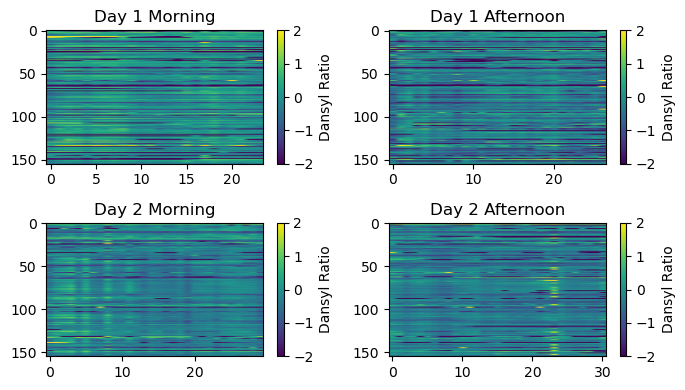

In [36]:
# plot imshow
plt.figure(figsize=(7, 4))
plt.subplot(2, 2, 1)
plt.imshow(X1m, aspect='auto', cmap='viridis',vmin=-2, vmax=2)
plt.colorbar(label='Dansyl Ratio')
plt.title('Day 1 Morning')
plt.subplot(2, 2, 2)
plt.imshow(X1a, aspect='auto', cmap='viridis', vmin= -2, vmax=2)
plt.colorbar(label='Dansyl Ratio')
plt.title('Day 1 Afternoon')
plt.subplot(2, 2, 3)
plt.imshow(X2m, aspect='auto', cmap='viridis', vmin= -2, vmax=2)
plt.colorbar(label='Dansyl Ratio')
plt.title('Day 2 Morning')
plt.subplot(2, 2, 4)
plt.imshow(X2a, aspect='auto', cmap='viridis', vmin= -2, vmax=2)
plt.colorbar(label='Dansyl Ratio')
plt.title('Day 2 Afternoon')
plt.tight_layout()
# plt.savefig('heatmaps_raw.pdf', dpi=300)
plt.show()

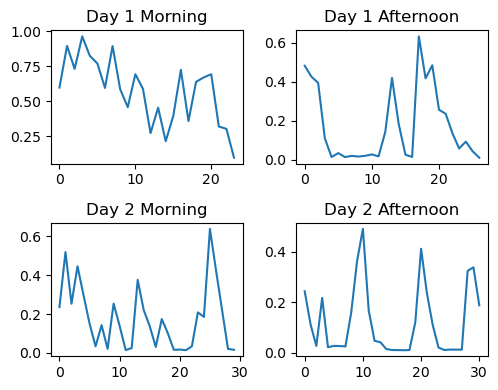

In [37]:
# plot the 4 speeds
plt.figure(figsize=(5, 4))
plt.subplot(2, 2, 1)
plt.plot(y1m)
plt.title('Day 1 Morning')
plt.subplot(2, 2, 2)
plt.plot(y1a)
plt.title('Day 1 Afternoon')
plt.subplot(2, 2, 3)
plt.plot(y2m)
plt.title('Day 2 Morning')
plt.subplot(2, 2, 4)
plt.plot(y2a)
plt.title('Day 2 Afternoon')
plt.tight_layout()
# plt.savefig('lineplots_raw.pdf', dpi=300)
plt.show()


In [38]:
# concatenate X1m, a np.zeros(9, 155), and X1a
X1_full = np.hstack((X1m, np.zeros((X1m.shape[0], 9))*np.nan, X1a))
y1_full = np.hstack((y1m, np.zeros(9)*np.nan, y1a))
# concatenate X2m, a np.zeros   (9, 155), and X2a
X2_full = np.hstack((X2m, np.zeros((X2m.shape[0], 9))*np.nan, X2a))
y2_full = np.hstack((y2m, np.zeros(9)*np.nan, y2a))

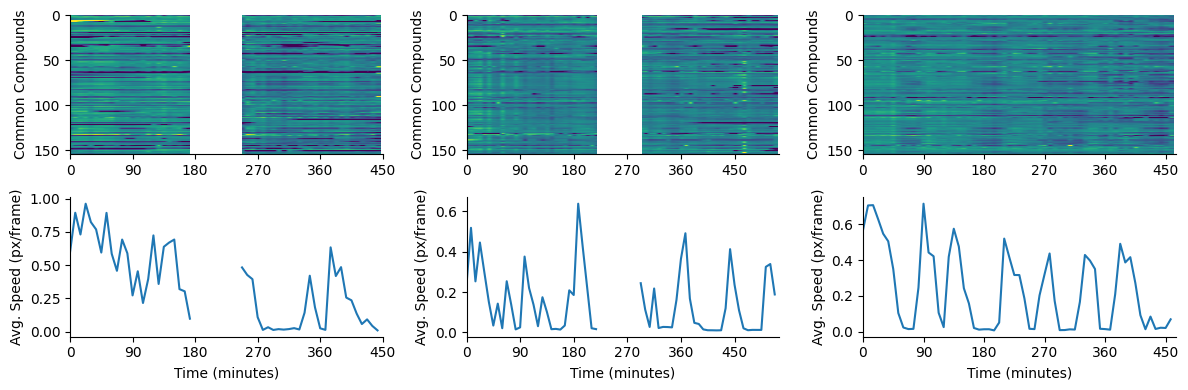

In [73]:
def anim_comps_speed(X, y, title='', pos=0):
    plt.subplot(2, 3, 1 + pos)
    plt.imshow(X, aspect='auto', cmap='viridis',vmin=-2.3, vmax=2.3)
    # plt.colorbar(label='Dansyl Ratio')
    plt.xticks([0,12,24,36,48,60],[0,90,180,270,360,450])
    plt.ylabel('Common Compounds')
    plt.xlim(0,len(y))
    # remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.subplot(2, 3, 4 + pos)
    plt.plot(y)
    plt.xticks([0,12,24,36,48,60],[0,90,180,270,360,450])
    plt.xlabel('Time (minutes)')
    plt.ylabel('Avg. Speed (px/frame)')
    plt.xlim(0,len(y))
    # remvoe spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
# plot imshow
plt.figure(figsize=(12, 4))
anim_comps_speed(X1_full, y1_full, title='Day 1', pos=0)
anim_comps_speed(X2_full, y2_full, title='Day 2', pos=1)
anim_comps_speed(X3, y3, title='Day 3', pos=2)
plt.tight_layout()
# plt.suptitle('Dansyl Ratios and Average Speed Over Time', y=
plt.savefig('heatmaps_lines_raw_aligned.pdf', dpi=300)